In [1]:
import numpy as np
import pandas as pd
# from tqdm import tqdm
# from scipy.sparse import coo_matrix
from pyspark.ml.recommendation import ALS

# import sklearn
# import random 

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [2]:
from pyspark.sql import SparkSession


MAX_MEMORY = "5g"
spark = SparkSession.builder.appName("recommender")\
.config("spark.executor.memory", MAX_MEMORY)\
.config("spark.driver.memory", MAX_MEMORY)\
.getOrCreate()

# spark = SparkSession\
#         .builder\
#         .appName('recommender_system')\
#         .getOrCreate()

22/05/16 15:16:50 WARN Utils: Your hostname, RedStone-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.38 instead (on interface en0)
22/05/16 15:16:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/16 15:16:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 데이터 불러오기
customers = pd.read_csv("data/customers.csv")
tran = pd.read_csv("data/transactions_train.csv")
item = pd.read_csv("data/articles.csv")

In [4]:
customers.head(3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...


In [5]:
tran['count'] = '1'


In [6]:
ALL_USERS = customers['customer_id'].unique().tolist()
ALL_ITEMS = item['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

tran['user_id'] = tran['customer_id'].map(user_map)
tran['item_id'] = tran['article_id'].map(item_map)

# del customers, customers


In [18]:
tran.head()

,t_dat,customer_id,article_id,price,sales_channel_id,count,user_id,item_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,1,2,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,1,2,10520
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1,7,6387
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1,7,46304
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1,7,46305


In [7]:
tran = tran.drop(['t_dat','price', 'sales_channel_id'], axis=1)
tran.head(20)

,customer_id,article_id,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,1,7,46305
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,1,7,46302
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,1,7,6386
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,1,198,47416
8,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,1,198,5944
9,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,1,198,22540


In [8]:
rfm = pd.read_csv("data/result.csv")

In [21]:
rfm.head(3)

,customer_id,article_id,price,t_dat,age,count,total,t_dat_R,count_F,total_M,Class
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023.0,0.035576,8467200.0,49.0,1,0.035576,2,1,8,2
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006.0,0.050831,21340800.0,49.0,2,0.101661,4,9,10,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043.0,0.050831,61862400.0,49.0,1,0.050831,10,1,9,1


In [9]:
rfm = rfm[['customer_id', 'article_id', 't_dat_R', 'count_F', 'total_M']]
sum_factor = (rfm['t_dat_R']*0.503095271342921) + (rfm['count_F']*0) + (rfm['total_M']*0.49690472865707896)
rfm['rfm'] = sum_factor

In [10]:
rfm = rfm.drop(['t_dat_R', 'count_F', 'total_M'], axis=1)

In [11]:
rfm.head()

,customer_id,article_id,rfm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023.0,4.981428
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006.0,6.981428
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043.0,9.503095
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008.0,3.509286
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001.0,5.478333


In [25]:
tran.head()

,customer_id,article_id,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,1,7,46305


In [11]:
rfm = rfm.merge(tran, on=['customer_id', 'article_id'], how='right')

In [12]:
# rfm['customer_id'] = rfm['customer_id'].astype(int)
# rfm['article_id'] = rfm['article_id'].astype(int)
rfm['rfm'].max()

10.0

In [3]:
rfm.to_csv('data/df4.csv', index=False)

NameError: name 'rfm' is not defined

In [17]:
rfm.head()

,customer_id,article_id,rfm,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,5.472143,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,3.484524,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,1.993809,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,1.993809,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,1.993809,1,7,46305


In [ ]:
# # coo 변환
# row = df['user_id'].values
# col = df['item_id'].values
# data = np.ones(tran.shape[0])
# coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
# coo_train

In [3]:
df_spark = spark.read.csv("data/df4.csv", inferSchema=True, header=True)
# coo_train = spark.createDataFrame(coo_train)

In [4]:
train, test = df_spark.randomSplit([0.75, 0.25])

rec = ALS(maxIter=10,
        regParam=0.01,
        userCol='user_id',
        itemCol='article_id',
        ratingCol='rfm', # label -> predict할 때는 필요 없음!
        nonnegative=True,
        # implicitPrefs = True,
        coldStartStrategy='drop')
# ALS모델 학습 -> dataframe을 넣어주기
rec_model = rec.fit(train)

# transform을 이용해 예측 -> dataframe을 넣어주기
pred_ratings = rec_model.transform(test)
pred_ratings.limit(5).toPandas()

22/05/16 15:17:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/16 15:17:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,customer_id,article_id,rfm,count,user_id,item_id,prediction
0,0001177027259b455f979d85a278e4b280205d4de5cce4...,843940001.0,7.503095,1,26,90626,9.113862
1,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,7.814641
2,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,7.814641
3,0001177027259b455f979d85a278e4b280205d4de5cce4...,834063003.0,8.000000,1,26,88639,10.048875
4,0001177027259b455f979d85a278e4b280205d4de5cce4...,841632001.0,8.496905,1,26,90137,8.083483


In [7]:
u = rec.recommandProducts(26, 10)

AttributeError: 'ALS' object has no attribute 'recommandProducts'

In [8]:
pred_ratings.limit(100).toPandas()

,customer_id,article_id,rfm,count,user_id,item_id,prediction
0,0001177027259b455f979d85a278e4b280205d4de5cce4...,820032004.0,6.012381,1,26,85498,6.732720
1,0001177027259b455f979d85a278e4b280205d4de5cce4...,810170001.0,8.993809,1,26,82831,9.572466
2,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,8.523146
3,0001177027259b455f979d85a278e4b280205d4de5cce4...,841632001.0,8.496905,1,26,90137,7.592326
4,0001177027259b455f979d85a278e4b280205d4de5cce4...,857716002.0,8.993809,1,26,93341,9.216869
...,...,...,...,...,...,...,...
95,000af9152a52736ff524a502573a9b0862929b8911b7c4...,637141005.0,5.472143,1,243,32979,5.438198
96,000af9152a52736ff524a502573a9b0862929b8911b7c4...,637141005.0,5.472143,1,243,32979,5.438198
97,000af9152a52736ff524a502573a9b0862929b8911b7c4...,842606003.0,7.503095,1,243,90354,4.354179
98,000c64b193364d6fc6b4936fda8e9e444ec8100da015fd...,412370001.0,2.490714,1,271,2533,0.160389


In [6]:
dd = pred_ratings.toPandas()

In [8]:
dd.head()

,customer_id,article_id,rfm,count,user_id,item_id,prediction
0,0001177027259b455f979d85a278e4b280205d4de5cce4...,843940001.0,7.503095,1,26,90626,9.113862
1,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,7.814641
2,0001177027259b455f979d85a278e4b280205d4de5cce4...,831429001.0,8.993809,1,26,88074,7.814641
3,0001177027259b455f979d85a278e4b280205d4de5cce4...,834063003.0,8.000000,1,26,88639,10.048875
4,0001177027259b455f979d85a278e4b280205d4de5cce4...,841632001.0,8.496905,1,26,90137,8.083483


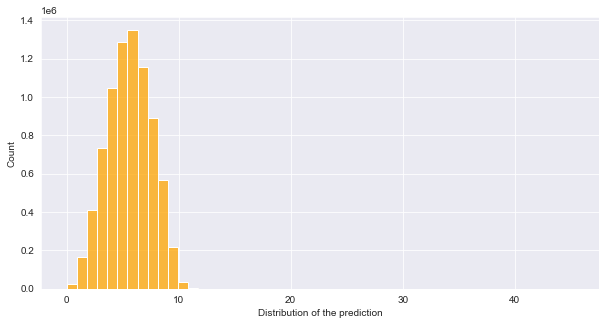

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=dd, x='prediction', bins=50, color='orange')
ax.set_xlabel('Distribution of the prediction')
plt.show()

In [5]:
# Get metric for training
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='rmse')
# evaluate 메소드에 예측값 담겨있는 dataframe 넣어주기
rmse = evaluator.evaluate(pred_ratings)

mae_eval = RegressionEvaluator(labelCol='rfm',
                              predictionCol='prediction',
                              metricName='mae')
mae = mae_eval.evaluate(pred_ratings)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 1.078285685998789
MAE: 0.7876156441920797


In [9]:
np.mean(np.abs((dd['rfm'] - dd['prediction']) / dd['rfm'])) * 100 

17.439025047197298

22/05/16 21:02:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 927247 ms exceeds timeout 120000 ms
22/05/16 21:02:36 WARN SparkContext: Killing executors is not supported by current scheduler.


In [12]:
# Pyspark Library #
# SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
# ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS


# stringIndexer = StringIndexer(inputCol='article_id',
#                             outputCol='article_new')
# print(stringIndexer)
# model = stringIndexer.bfit(df)
# indexed = model.transform(df)

# 숫자로 바꾼 영화제목들 중 Unique한 값들만 담아 추출하기 -> Dataframe 반환





In [56]:
pre1 = rfm
pre1.head(10)

,customer_id,article_id,rfm,count,user_id,item_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001.0,20,1,2,40179
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023.0,8,1,2,10520
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004.0,5,1,7,6387
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003.0,5,1,7,46304
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004.0,5,1,7,46305
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001.0,5,1,7,46302
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001.0,6,1,7,6386
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012.0,8,1,198,47416
8,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011.0,11,1,198,5944
9,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003.0,11,1,198,22540


In [14]:
df = spark.read.csv('data/df4.csv', inferSchema=True, header=True)
unique_movies = df.select("article_id").distinct()

def top_movies(user_id, n):
    """
    특정 user_id가 좋아할 만한 n개 추천해주는 함수
    """
    # unique_movies 데이터프레임을 'a'라는 데이터프레임으로 alias시키기
    a = unique_movies.alias('a')

    # 특정 user_id가 본 영화들만 담은 새로운 데이터프레임 생성
    watched_movies = df.filter(df['user_id'] == user_id)\
                            .select('article_id')

    # 특정 user_id가 본 영화들을 'b'라는 데이터프레임으로 alias시키기
    b = watched_movies.alias('b')

    # unique_movies를 기준으로 watched_movies를 조인시켜서 user_id가 보지 못한 영화들 파악 가능
    total_movies = a.join(b, a['article_id'] == b['article_id'],
                        how='left')

    # b 데이터프레임의 title_new값이 결측치를 갖고 있는 행의 a.title_new를 뽑아냄으로써 user_id가 아직 못본 영화들 추출
    # col('b.title_new') => b 데이터프레임의 title_new칼럼 의미(SQL처럼 가능!)
    remaining_movies = total_movies\
                    .where(col('b.article_id').isNull())\
                    .select('a.article_id').distinct()
    # remaining_movies 데이터프레임에 특정 user_id값을 동일하게 새로운 변수로 추가해주기
    remaining_movies = remaining_movies.withColumn('user_id',
                                                lit(int(user_id)))
    # 위에서 만든 ALS 모델을 사용하여 추천 평점 예측 후 n개 만큼 view -> 
    recommender = rec_model.transform(remaining_movies)\
                        .orderBy('prediction', ascending=False)\
                        .limit(n)

    # pre = recommender.toPandas()
    # pre1 = rfm.merge(pre, on=['user_id', 'article_id'], how='right')
    # pre1 = rfm.merge(pre)
    # return pre
    return recommender.show(n, truncate=False)

# userid가 1817번인 유저 상위 5개 추천해주기
top_movies(30, 100)

+------------+-------+----------+
|article_id  |user_id|prediction|
+------------+-------+----------+
|9.15851002E8|30     |57.864025 |
|7.46398001E8|30     |54.268055 |
|9.09817001E8|30     |53.9986   |
|8.76471001E8|30     |53.80548  |
|9.09817002E8|30     |52.380264 |
|9.03210004E8|30     |49.134834 |
|6.43363001E8|30     |48.131157 |
|8.25437009E8|30     |47.921597 |
|8.06955002E8|30     |46.720207 |
|6.86129006E8|30     |46.49929  |
|8.50795002E8|30     |46.24418  |
|9.06372001E8|30     |45.985428 |
|7.90340004E8|30     |45.85562  |
|7.96732003E8|30     |45.311    |
|8.38358002E8|30     |44.986977 |
|4.97637024E8|30     |44.22743  |
|5.78626019E8|30     |43.790264 |
|9.01950003E8|30     |41.24415  |
|8.57351001E8|30     |40.627403 |
|8.70579002E8|30     |38.724762 |
|8.42055002E8|30     |37.237934 |
|7.58626001E8|30     |36.657806 |
|5.85651001E8|30     |36.378838 |
|9.06183001E8|30     |36.361416 |
|7.28618001E8|30     |36.08702  |
|5.66556012E8|30     |36.027084 |
|7.34930003E8|

22/05/09 23:18:41 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 562579 ms exceeds timeout 120000 ms
22/05/09 23:18:41 WARN SparkContext: Killing executors is not supported by current scheduler.
22/05/10 10:52:09 WARN TransportChannelHandler: Exception in connection from /172.30.1.58:54603
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.n